# Requirement Installation

In [0]:
!pip install PyDrive
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install Augmentor

    100% |████████████████████████████████| 993kB 20.2MB/s 
  Running setup.py bdist_wheel for PyDrive ... - done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


#**Imports Section**

---



In [0]:
import os, random, shutil, math
from collections import Counter
import Augmentor
import cv2 as cv
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
from tensorflow.python.client import device_lib
from google.colab import drive

# Basic Setup


---



In [0]:
#@title
device_lib.list_local_devices()
drive.mount('/content/gdrive')

base_dir = '/content/gdrive/My Drive/Datasets/orignal'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data Processing Functions


---



In [0]:
"""
Description:=> This function shuffles the data and labels by zipping them together
Parameters:=> Two
1) "data" || array of data(images (256,256,3))
2) "label" || array of label (depends upon classes)
"""

def shuffle_data(data, label):
    data = np.array(data, dtype=float)
    label = np.array(label, dtype=int)
    data, label = shuffle(data, label)
    return data, label

In [0]:
""" 
Description:=> This function count files in the directory
Parameters:=> One
1) "folder_path" || path of the directory, you want to count files of
"""

def total_files(folder_path=""):
    dirs = os.walk(folder_path)
    files_count =0
    for s_dir in dirs:
        dir_path = s_dir[0]
        dir_files = s_dir[2]
        dir_name = os.path.basename(dir_path)

        print(f'{dir_name}: {len(dir_files)}')
        files_count = files_count + len(dir_files)
    print(f"Total Filess:= {files_count}")
    return int(files_count)

In [0]:
"""
Description:=> You give this folder path, it will return array of data and labels in shuffeled form
Parameters:=> Three
1) "folder_path" || path of directory, from where you want to read images
2) "img_h" || height of images if you want to adjust them (default is 128)
3) "img_w" || height of images if you want to adjust them (default is 128)
"""

def get_data(folder_path="", img_h=128, img_w=128):
    dirs = os.walk(folder_path)

    master_data = []
    master_labels = []
    image_sizes = []
    none_data = 0

    for s_dir in dirs:
        dir_path = s_dir[0]
        dir_files = s_dir[2]
        dir_name = os.path.basename(dir_path)
        for file in dir_files:
            file_path = os.path.join(dir_path, file)

            image = cv.imread(file_path)
            i_height = np.size(image, 0)
            i_width = np.size(image, 1)

            image_sizes.append([i_height, i_width])

            # file_data = np.array(cv.imread(file_path, cv.IMREAD_GRAYSCALE))
            file_data = np.array(cv.imread(file_path))

            if (file_data.any() != None):
                
                if (i_height != img_h or i_width != img_w):
                    file_data = cv.resize(file_data, dsize=(img_h, img_w), interpolation=cv.INTER_LANCZOS4)
                    
                # Image Shape: Height x Width x Depth(RGB)
                reshaped_data = file_data.reshape((file_data.shape[0]), (file_data.shape[1]), 3)
                master_data.append(reshaped_data)
                master_labels.append(np.array([dir_name]))
                # master_labels.append(np.array([((int(os.path.basename(dir_path)))-1)]))
            else:
                print(file_path)
                none_data += 1
        print(f'Directory:=> {dir_path}')
        
    print(f'Total Images: {len(master_data)} || Total Labels: {len(master_labels)} || Total Errors: {none_data}')
    return shuffle_data(master_data, master_labels)


# Augmentation Functions

---



In [0]:
def orignal_to_train_test():
  dbase_dir = '/content/gdrive/My Drive/Datasets/orignal'
  train_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/train'
  test_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/test'

  dirs = os.walk(dbase_dir)
  for s_dir in dirs:
      dir_path = s_dir[0]
      dir_files = s_dir[2]

      if (dir_files != 0):
          dir_name = os.path.basename(dir_path)

          test_files = random.sample(dir_files, int(0.2 * len(dir_files)))
          train_files = list(set(dir_files) - set(test_files))

          print(f'Directory: {dir_name} || Test Files: {len(test_files)} || Train Files: {len(train_files)}')

          os.mkdir(os.path.join(test_dir, str(dir_name)))
          os.mkdir(os.path.join(train_dir, str(dir_name)))

          current_test_dir = os.path.join(test_dir, str(dir_name))
          current_train_dir = os.path.join(train_dir, str(dir_name))

          for fname in test_files:
              srcpath = os.path.join(dir_path, fname)
              shutil.copy(srcpath, current_test_dir)

          for fname in train_files:
              srcpath = os.path.join(dir_path, fname)
              shutil.copy(srcpath, current_train_dir)


In [0]:
def do_augmentation(input_dir="", output_dir="", max_files=0, max_folder=""):
    dirs = os.walk(input_dir)
    for s_dir in dirs:
        dir_path = s_dir[0]
        dir_files = s_dir[2]
        dir_name = os.path.basename(dir_path)

        print(f'Inside Folder: {dir_path}')
        print(f'Total Files: {len(dir_files)}')

        if(len(dir_files) != 0):
          if(dir_name != max_folder):
              new_dataset = os.path.join(output_dir, dir_name)
              p = Augmentor.Pipeline(source_directory=dir_path, output_directory=new_dataset)
              p.flip_left_right(probability=1)
              p.flip_top_bottom(probability=0.85)
              p.rotate(probability=0.90, max_left_rotation=25, max_right_rotation=25)
              p.zoom_random(probability=0.25, percentage_area=0.35)
              p.crop_centre(probability=0.85, percentage_area=0.75)
              p.crop_random(probability=0.75, percentage_area=0.65)
              #p.resize(probability=1.0, width=256, height=256)
              p.sample(int((max_files / (len(dir_files))) * (len(dir_files))))
          else:
              os.mkdir(os.path.join(output_dir, str(dir_name)))
              outpath = os.path.join(output_dir, dir_name)
              for fname in dir_files:
                srcpath = os.path.join(dir_path, fname)
                shutil.copy(srcpath, outpath)

    return "All Gone Well"


In [0]:
def read_image(img_path="", img_h=128, img_w=128):
    image = cv.imread(img_path)
    i_height = np.size(image, 0)
    i_width = np.size(image, 1)

    file_data = np.array(cv.imread(img_path))

    if (file_data.any() != None):
        if (i_height != img_h or i_width != img_w):
            file_data = cv.resize(file_data, dsize=(img_h, img_w), interpolation=cv.INTER_LANCZOS4)

        file_data = file_data.reshape((file_data.shape[0]), (file_data.shape[1]), 3)
        return file_data
    else:
        return None


def data_generator(folder_path="", img_h=128, img_w=128, batch_size=128):
    dirs = os.walk(folder_path)

    paths_labels = []

    for s_dir in dirs:
        dir_path = s_dir[0]
        dir_files = s_dir[2]
        for file in dir_files:
            single_image_path = os.path.join(dir_path, file)
            single_image_label = os.path.basename(dir_path)
            paths_labels.append([single_image_path, single_image_label])

    random.shuffle(paths_labels)
    tdata_len = len(paths_labels)
    iterations = math.ceil(tdata_len / batch_size)

    for count in range(iterations):
        m_data = []
        m_label = []

        if ((count + 1) * batch_size < tdata_len):
            to_loop = paths_labels[count * batch_size:(count + 1) * batch_size]
            for img in to_loop:
                m_data.append(read_image(img[0], img_h, img_w))
                m_label.append([int(img[1])-1])
            yield np.array(m_data, dtype=float), np.array(m_label)
        else:
            to_loop = paths_labels[count * batch_size:]
            for img in to_loop:
                m_data.append(read_image(img[0], img_h, img_w))
                m_label.append([int(img[1])-1])
                yield np.array(m_data, dtype=float), np.array(m_label)


**Augmentation Intialization Code**

**WARNING**: *Before Calling Check The Folder Structure, Because This Is Not Creating New Directories But Generating in The Old Ones*

In [0]:
#This call will split the 20% data randomly in the folders mentioned in the function.
#orignal_to_train_test()

In [0]:
# This is augmentation of data, according to the definition given in the function.

train_aug_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/train_aug'
test_aug_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/test_aug'

train_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/train'
test_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/test'


#a = do_augmentation(test_dir, test_aug_dir, 376, '6')
#print(f'Test Data Augmentation: {a}')

b = do_augmentation(train_dir, train_aug_dir, 1504, '6')
print(f'Test Data Augmentation: {b}')

Executing Pipeline:   0%|          | 0/1504 [00:00<?, ? Samples/s]

Inside Folder: /content/gdrive/My Drive/Datasets/tt_dataset/train
Total Files: 0
Inside Folder: /content/gdrive/My Drive/Datasets/tt_dataset/train/7
Total Files: 47
Initialised with 47 image(s) found.
Output directory set to /content/gdrive/My Drive/Datasets/tt_dataset/train_aug/7.

Processing <PIL.Image.Image image mode=RGB size=480x359 at 0x7FD22001FD30>: 100%|██████████| 1504/1504 [01:13<00:00, 20.44 Samples/s]
Executing Pipeline:   0%|          | 0/1504 [00:00<?, ? Samples/s]

Inside Folder: /content/gdrive/My Drive/Datasets/tt_dataset/train/1
Total Files: 93
Initialised with 93 image(s) found.
Output directory set to /content/gdrive/My Drive/Datasets/tt_dataset/train_aug/1.

Processing <PIL.Image.Image image mode=RGB size=312x234 at 0x7FD220034AC8>: 100%|██████████| 1504/1504 [01:10<00:00, 21.38 Samples/s]
Executing Pipeline:   0%|          | 0/1504 [00:00<?, ? Samples/s]

Inside Folder: /content/gdrive/My Drive/Datasets/tt_dataset/train/4
Total Files: 63
Initialised with 63 image(s) found.
Output directory set to /content/gdrive/My Drive/Datasets/tt_dataset/train_aug/4.

Processing <PIL.Image.Image image mode=RGB size=634x399 at 0x7FD222357668>: 100%|██████████| 1504/1504 [01:59<00:00, 12.54 Samples/s]
Executing Pipeline:   0%|          | 0/1504 [00:00<?, ? Samples/s]

Inside Folder: /content/gdrive/My Drive/Datasets/tt_dataset/train/2
Total Files: 84
Initialised with 84 image(s) found.
Output directory set to /content/gdrive/My Drive/Datasets/tt_dataset/train_aug/2.

Processing <PIL.Image.Image image mode=RGB size=172x191 at 0x7FD22026BE80>: 100%|██████████| 1504/1504 [01:42<00:00, 14.64 Samples/s]
Executing Pipeline:   0%|          | 0/1504 [00:00<?, ? Samples/s]

Inside Folder: /content/gdrive/My Drive/Datasets/tt_dataset/train/3
Total Files: 58
Initialised with 58 image(s) found.
Output directory set to /content/gdrive/My Drive/Datasets/tt_dataset/train_aug/3.

Processing <PIL.Image.Image image mode=RGB size=336x296 at 0x7FD220034588>: 100%|██████████| 1504/1504 [00:57<00:00, 26.02 Samples/s]
Executing Pipeline:   0%|          | 0/1504 [00:00<?, ? Samples/s]

Inside Folder: /content/gdrive/My Drive/Datasets/tt_dataset/train/5
Total Files: 45
Initialised with 45 image(s) found.
Output directory set to /content/gdrive/My Drive/Datasets/tt_dataset/train_aug/5.

Processing <PIL.Image.Image image mode=RGB size=148x234 at 0x7FD116A5A390>: 100%|██████████| 1504/1504 [01:07<00:00, 22.41 Samples/s]


Inside Folder: /content/gdrive/My Drive/Datasets/tt_dataset/train/6
Total Files: 1504
Test Data Augmentation: All Gone Well


In [0]:
total_files('/content/gdrive/My Drive/Datasets/tt_dataset/train_aug')

train_aug: 0
7: 1504
1: 1504
4: 1504
2: 1504
3: 1504
5: 1504
6: 1504
Total Filess:= 10528


10528

In [0]:
#Total Files Count Checking

# Model Helper Functions

In [0]:
def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    y = np.ravel(y)
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority / count) for cls, count in counter.items()}

In [0]:
#Balance Test Batch Generation
def get_balance_random_test(folder_path="", img_h=300, img_w=300, batch_size=64, num_of_classes=7, test=35):
  dirs = os.walk(folder_path)
  
  samples = int(batch_size/num_of_classes)
  
  
  
  for num in range(test):
    m_data = []
    m_label = []
    dirs = os.walk(folder_path)
    
    for s_dir in dirs:
          dir_path = s_dir[0]
          dir_files = s_dir[2]
          dir_name = os.path.basename(dir_path)

          if(len(dir_files) > 0):
            tfiles = random.sample(dir_files, samples)
            for file in tfiles:
              single_image_path = os.path.join(dir_path, file)
              single_image_label = dir_name
              m_data.append(read_image(single_image_path, img_h, img_w))
              m_label.append([int(dir_name)-1])
    yield shuffle_data(m_data, m_label)
  



---



---


# Model Test # 1


---



**ATTEMPT # 1**


*   Batch Size 32
*   Epochs 50



---





In [0]:
# Parameters Setting #
#=====================#
epochs = 50
batch_size = 32

# Input Dimentions
img_h = 300
img_w = 300
channels = 3

input_shape = (img_h, img_w, channels)

In [0]:
#m1_test_d, m1_test_l = get_data('/content/gdrive/My Drive/Datasets/tt_dataset/test', img_h, img_w)
#m1_train_d, m1_train_l = get_data('/content/gdrive/My Drive/Datasets/tt_dataset/train', img_h, img_w)

# Single data set for training and testing using validation siplit of 0.2
m1_data, m1_labels = get_data('/content/gdrive/My Drive/Datasets/orignal', img_h, img_w)

Directory:=> /content/gdrive/My Drive/Datasets/orignal
Directory:=> /content/gdrive/My Drive/Datasets/orignal/7
Directory:=> /content/gdrive/My Drive/Datasets/orignal/1
Directory:=> /content/gdrive/My Drive/Datasets/orignal/4
Directory:=> /content/gdrive/My Drive/Datasets/orignal/2
Directory:=> /content/gdrive/My Drive/Datasets/orignal/3
Directory:=> /content/gdrive/My Drive/Datasets/orignal/5
Directory:=> /content/gdrive/My Drive/Datasets/orignal/6
Total Images: 2364 || Total Labels: 2364 || Total Errors: 0


In [0]:
def ModelTwo(input_shape=(300, 300, 3), num_classes=7):
  
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(16, kernel_size=(1, 1), activation='relu'))
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(32, kernel_size=(1, 1), activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(1, 1), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(1, 1), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    
    model.add(AveragePooling2D(pool_size=(7, 7)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2)) #added for attempt three
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()

    return model

In [0]:
class_weights = get_class_weights(m1_labels-1, 0.1)
print(f'Balanced Class Weights:=> {class_weights}')

model = ModelTwo(input_shape=input_shape)

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# label-1 because keras start counting classes from zero
history = model.fit(m1_data, m1_labels-1,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, shuffle=True, validation_split=0.2, class_weight=class_weights)

Balanced Class Weights:=> {5: 1.0, 3: 7.773223016171494, 2: 7.952674105425165, 0: 6.801250411319514, 1: 7.05667463298054, 4: 8.474374743747438, 6: 8.405449369662465}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 298, 298, 16)      272       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 296, 296, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 146, 146, 32)      4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 146, 1

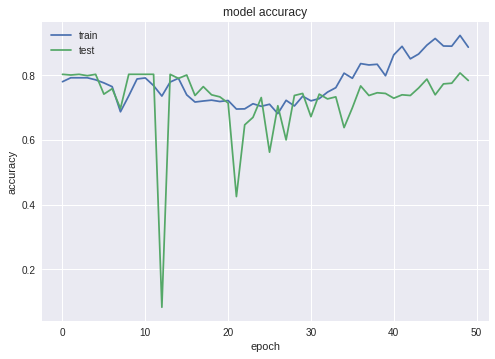

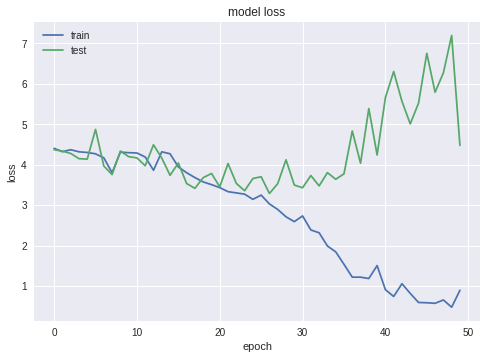

In [0]:
# summarizing accuracy/epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize loss/epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



---
**Attempt # 2**


*   Batch Size: 16
*   Epochs: 80
*   Learning Rate: 0.00001

---



In [0]:
batch_size = 16 
epochs = 80

class_weights = get_class_weights(m1_labels-1, 0.1)
print(f'Balanced Class Weights:=> {class_weights}')

model = ModelTwo(input_shape=input_shape)

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.00001),
              metrics=['accuracy'])

# label-1 because keras start counting classes from zero
history = model.fit(m1_data, m1_labels-1,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, shuffle=True, validation_split=0.2, class_weight=class_weights)

Balanced Class Weights:=> {5: 1.0, 3: 7.773223016171494, 2: 7.952674105425165, 0: 6.801250411319514, 1: 7.05667463298054, 4: 8.474374743747438, 6: 8.405449369662465}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 298, 298, 16)      272       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 296, 296, 16)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 146, 146, 32)      4640      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 146, 1

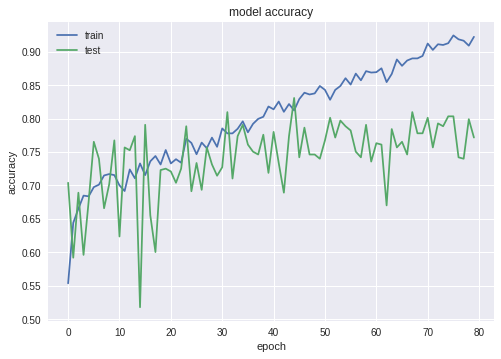

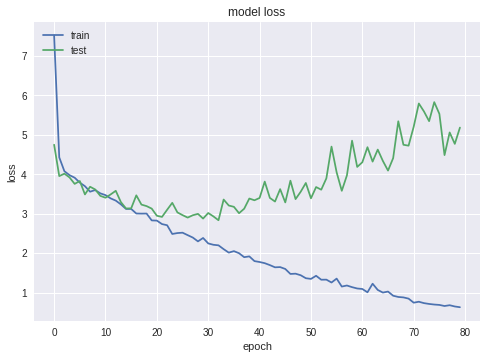

In [0]:
# summarizing accuracy/epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize loss/epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



---
**Attempt # 3**


*   Batch Size: 128
*   Epochs: 50
*   Learning Rate: Default
*   Optimizer: SGD

---



In [0]:
batch_size = 16
epochs = 25

class_weights = get_class_weights(m1_labels-1, 0.1)
print(f'Balanced Class Weights:=> {class_weights}')

model = ModelTwo(input_shape=input_shape)

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

# label-1 because keras start counting classes from zero
history = model.fit(m1_data, m1_labels-1,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, shuffle=True, validation_split=0.2, class_weight=class_weights)

Balanced Class Weights:=> {5: 1.0, 1: 7.05667463298054, 3: 7.773223016171494, 6: 8.405449369662465, 0: 6.801250411319514, 4: 8.474374743747438, 2: 7.952674105425165}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 298, 298, 16)      272       
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 296, 296, 16)      2320      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 146, 146, 32)      4640      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 146, 1

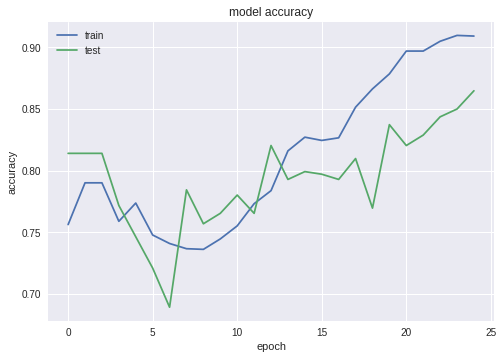

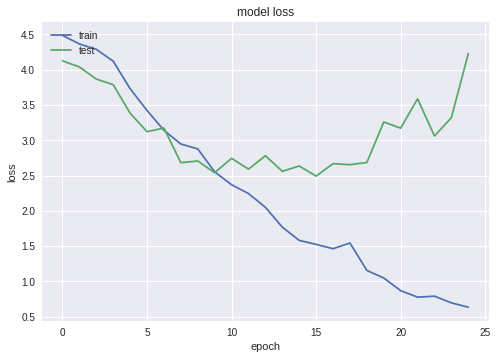

In [0]:
# summarizing accuracy/epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize loss/epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



---
**Attempt # 4**


*   Batch Size: 32
*   Epochs: 50
*   Learning Rate: Default
*   Optimizer: Adam

**Important: Test dataset is balanced but training left the same and controlled via defining class weights to them**
---



In [0]:
#train_data_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/train'
#test_data_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/test'

#train_generator = data_generator(train_data_dir, img_h, img_w, batch_size)
#val_generator = data_generator(test_data_dir, img_h, img_w, batch_size)

#test_files = total_files(test_data_dir)
#train_files = total_files(train_data_dir)

#steps_per_epoch = math.ceil(train_files/batch_size)
#validation_steps = math.ceil(test_files/batch_size)

# Single data set for training and testing using validation siplit of 0.2
train_data, train_labels = get_data('/content/gdrive/My Drive/Datasets/tt_dataset/train', img_h, img_w)

Directory:=> /content/gdrive/My Drive/Datasets/tt_dataset/train
Directory:=> /content/gdrive/My Drive/Datasets/tt_dataset/train/7
Directory:=> /content/gdrive/My Drive/Datasets/tt_dataset/train/1
Directory:=> /content/gdrive/My Drive/Datasets/tt_dataset/train/4
Directory:=> /content/gdrive/My Drive/Datasets/tt_dataset/train/2
Directory:=> /content/gdrive/My Drive/Datasets/tt_dataset/train/3
Directory:=> /content/gdrive/My Drive/Datasets/tt_dataset/train/5
Directory:=> /content/gdrive/My Drive/Datasets/tt_dataset/train/6
Total Images: 1894 || Total Labels: 1894 || Total Errors: 0


In [0]:
batch_size = 32
epochs = 75

class_weights = get_class_weights(train_labels-1, 0.1)
print(f'Balanced Class Weights:=> {class_weights}')

model = ModelTwo(input_shape=input_shape)

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

# label-1 because keras start counting classes from zero
history = model.fit(train_data, train_labels-1,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, shuffle=True, class_weight=class_weights)

Balanced Class Weights:=> {5: 1.0, 4: 8.466734902763562, 0: 6.797041906327034, 1: 7.0580204778157, 6: 8.380952380952381, 3: 7.752577319587629, 2: 7.938579654510557}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 298, 298, 16)      272       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 296, 296, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 146, 146, 32)      4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 146, 14

KeyError: ignored

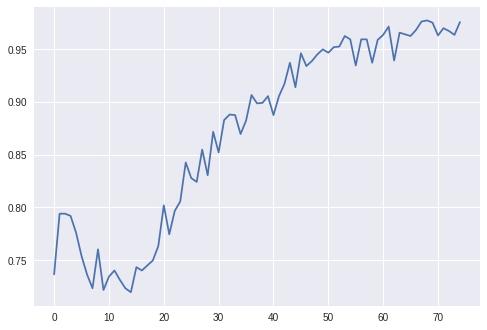

In [0]:
# summarizing accuracy/epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize loss/epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
total_files('/content/gdrive/My Drive/Datasets/tt_dataset/test')
test_batch_generator = get_balance_random_test('/content/gdrive/My Drive/Datasets/tt_dataset/test')
acc = []
for test_d, test_l in test_batch_generator:
  print(test_d.shape)
  print(test_l.shape)
  result = model.test_on_batch(test_d,test_l)
  acc.append(result[1])
  print(f'Sample Size:=> {len(test_d)} | {len(test_l)} |=| Loss:=> {result[0] } |=| Accuracy:=> {result[1]}')


test: 0
7: 11
1: 23
4: 15
2: 21
3: 14
5: 11
6: 375
Total Filess:= 470
(63, 300, 300, 3)
(63, 1)
Sample Size:=> 63 | 63 |=| Loss:=> 2.582735538482666 |=| Accuracy:=> 0.682539701461792
(63, 300, 300, 3)
(63, 1)
Sample Size:=> 63 | 63 |=| Loss:=> 3.313852548599243 |=| Accuracy:=> 0.6349206566810608
(63, 300, 300, 3)
(63, 1)
Sample Size:=> 63 | 63 |=| Loss:=> 2.795924186706543 |=| Accuracy:=> 0.6507936716079712
(63, 300, 300, 3)
(63, 1)
Sample Size:=> 63 | 63 |=| Loss:=> 2.602280616760254 |=| Accuracy:=> 0.6349206566810608
(63, 300, 300, 3)
(63, 1)
Sample Size:=> 63 | 63 |=| Loss:=> 2.568138599395752 |=| Accuracy:=> 0.6190476417541504
(63, 300, 300, 3)
(63, 1)
Sample Size:=> 63 | 63 |=| Loss:=> 2.9467740058898926 |=| Accuracy:=> 0.6190476417541504
(63, 300, 300, 3)
(63, 1)
Sample Size:=> 63 | 63 |=| Loss:=> 2.6837985515594482 |=| Accuracy:=> 0.5714285969734192
(63, 300, 300, 3)
(63, 1)
Sample Size:=> 63 | 63 |=| Loss:=> 2.748354196548462 |=| Accuracy:=> 0.6507936716079712
(63, 300, 300, 3)

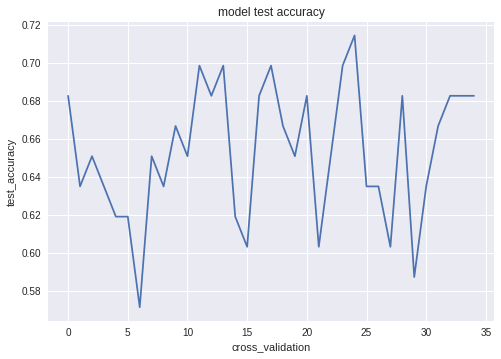

In [0]:
plt.plot(acc)
plt.title('model test accuracy')
plt.ylabel('test_accuracy')
plt.xlabel('cross_validation')
plt.show()



---


**Attempt 5**



*   Only Augmenting Images Of Training Data not of test data
*   Balanced test Check




In [0]:
total_files('/content/gdrive/My Drive/Datasets/tt_dataset/train_aug')

train_aug: 0
7: 1504
1: 1504
4: 1504
2: 1504
3: 1504
5: 1504
6: 1504
Total Filess:= 10528


10528

In [0]:
train_data, train_labels = get_data('/content/gdrive/My Drive/Datasets/tt_dataset/train_aug', img_h, img_w)

In [0]:
test_data_generator = get_balance_random_test('/content/gdrive/My Drive/Datasets/tt_dataset/test')

In [0]:
batch_size = 64
epochs = 60

#class_weights = get_class_weights(train_labels-1, 0.1)
#print(f'Balanced Class Weights:=> {class_weights}')

model = ModelTwo(input_shape=input_shape)

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# label-1 because keras start counting classes from zero
history = model.fit(train_data, train_labels-1,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, shuffle=True)



---


# Model Test # 2


---



In [0]:
# Parameters Setting #
#=====================#
epochs = 50
batch_size = 32

# Input Dimentions
img_h = 224
img_w = 224
channels = 3

input_shape = (img_h, img_w, channels)

In [0]:
def VGG_16(input_shape=(300,300,3), weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=input_shape))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #model.add(ZeroPadding2D((1,1)))
    #model.add(Convolution2D(512, 3, 3, activation='relu'))
    #model.add(ZeroPadding2D((1,1)))
    #model.add(Convolution2D(512, 3, 3, activation='relu'))
    #model.add(ZeroPadding2D((1,1)))
    #model.add(Convolution2D(512, 3, 3, activation='relu'))
    #model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model


In [0]:
batch_size = 16
class_weights = get_class_weights(m1_labels-1, 0.1)
print(f'Balanced Class Weights:=> {class_weights}')

model = VGG_16()

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# label-1 because keras start counting classes from zero
history = model.fit(m1_data, m1_labels-1,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, shuffle=True, validation_split=0.2, class_weight=class_weights)

# Temporary Code Test

---



In [0]:
test_d, test_l = get_data('/content/gdrive/My Drive/Datasets/tt_dataset/test_aug', img_h, img_w)
train_d, train_l = get_data('/content/gdrive/My Drive/Datasets/tt_dataset/train_aug', img_h, img_w)

In [0]:
#img_size = 128 x 128
batch_size = 128
epochs = 50

#Model two, one maxpool after 2 cov sets
model = ModelTwo(input_shape)

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_d, train_l-1,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, shuffle=True, validation_data=(test_d, test_l-1))

In [0]:

train_aug_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/train_aug'
test_aug_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/test_aug'

train_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/train'
test_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/test'


a = do_augmentation(train_dir, train_aug_dir, 1504, '6')
print(f'Test Data Augmentation: {a}')

# PLOTS

---



In [0]:
b = total_files(train_aug_dir)